In [7]:
import numpy as np
import pandas as pd
import random
big = pd.read_csv("bigfaultmatrixplustime.txt")
big.rename(columns={big.columns[-1]: 'execution_time'}, inplace=True)
fault_coverage = big.iloc[:, 1:-1].sum(axis=1).tolist()  # Sum of 1s in test columns

from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

In [7]:
big

,t0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,execution_time
0,t1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,25
1,t10,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,14
2,t100,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,24
3,t1000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
4,t10000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,t10893,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,10
995,t10894,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,20
996,t10895,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,9
997,t10896,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,19


In [1]:
# Create the fitness function
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0))  # Minimize negative fault coverage, maximize execution time
creator.create("Individual", list, fitness=creator.FitnessMulti)
# ... (rest of the DEAP setup as before)



def evaluate(individual):
    selected_tests = [i for i, bit in enumerate(individual) if bit == 1]
    
    fault_coverage = sum(big['1'][i] for i in selected_tests)
    execution = sum(big['execution_time'][i] for i in selected_tests)
    fitness = (-fault_coverage, execution)  # Negative fault coverage for maximization
    return fitness
# Create the toolbox
toolbox = base.Toolbox()

# Register functions for individual creation, evaluation, etc.
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(small))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.0)
toolbox.register("select", tools.selTournament, tournsize=5)
population = toolbox.population(n=1000)


hof = tools.HallOfFame(100)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std,  axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.2, mutpb=0.5, ngen=10, stats=stats, halloffame=hof, verbose=True)

pareto_front = tools.selNSGA2(population, len(population))



NameError: name 'creator' is not defined

Best random solution fitness: -1.0
Best GA solution fitness: -8.0


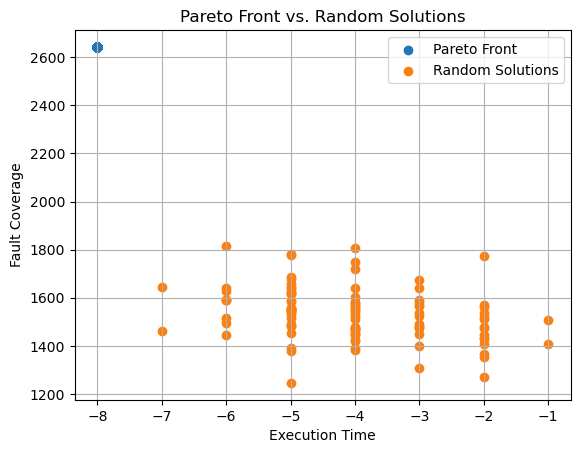

In [25]:

import random
import matplotlib.pyplot as plt

num_random_solutions = 100
random_solutions = [toolbox.individual() for _ in range(num_random_solutions)]

# Evaluate random solutions
for solution in random_solutions:
    solution.fitness.values = toolbox.evaluate(solution)
     
# Find the best random solution
best_random_solution = max(random_solutions, key=lambda x: x.fitness.values[0])

# Compare to the best GA solution
best_ga_solution = hof[0]

print("Best random solution fitness:", best_random_solution.fitness.values[0])
print("Best GA solution fitness:", best_ga_solution.fitness.values[0])

# Visualize the Pareto Front and Random Solutions
pareto_front = tools.selNSGA2(population, len(population))
pareto_x, pareto_y = zip(*[(ind.fitness.values[0], ind.fitness.values[1]) for ind in pareto_front])

random_x, random_y = zip(*[(ind.fitness.values[0], ind.fitness.values[1]) for ind in random_solutions])

plt.scatter(pareto_x, pareto_y, label="Pareto Front")
plt.scatter(random_x, random_y, label="Random Solutions")
plt.xlabel("Execution Time")
plt.ylabel( "Fault Coverage")
plt.title("Pareto Front vs. Random Solutions")
plt.legend()
plt.grid(True)
plt.show()